pacu data에 preop(NRS 0)를 얼마나 추가하냐에 따른 auroc, auprc

# train, test loading

In [5]:
import pandas as pd


print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess3/input3-2/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']

y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)


x_test2 = np.concatenate((x_test_pacu, x_test_preop[:int(len(x_test_preop)/2)]), axis = 0)
y_test2 = np.concatenate((y_test_pacu, y_test_preop[:int(len(y_test_preop)/2)]), axis = 0)

x_test2 = np.transpose(x_test2, [0,2,1])
x_test_pacu = np.transpose(x_test_pacu, [0,2,1])

x_test2[:,:,0] = pd.DataFrame(x_test2[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test2[:,:,1] = pd.DataFrame(x_test2[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x_test_pacu[:,:,0] = pd.DataFrame(x_test_pacu[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test_pacu[:,:,1] = pd.DataFrame(x_test_pacu[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values



print('x_train shape:', x_train.shape)
print('x_val.shape:', x_val.shape)
print('x_test.shape:', x_test.shape)
print('x_test_pacu+0.5preop.shape:', x_test2.shape)
print('x_test pacu.shape:', x_test_pacu.shape)


loading train...done
x_train shape: (78513, 5000, 2)
x_val.shape: (8707, 5000, 2)
x_test.shape: (9344, 5000, 2)
x_test_pacu+0.5preop.shape: (8480, 5000, 2)
x_test pacu.shape: (7617, 5000, 2)


In [6]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal


import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


4 Physical GPUs, 4 Logical GPUs


# Model Evaluation: binary(2 class)

## Labeling classes

In [7]:
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_test_bin2 = y_test >= 7

y_test2_bin = y_test2 >= 4
y_test_pacu_bin = y_test_pacu >= 4
y_val_bin = y_val >= 4

## Sample weight

In [13]:
# 2 class에 대한 sample weight
test_w_samp2 = np.ones(shape=(len(y_test),))
test_w_samp2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin)
test_w_samp2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin)

test_w_samp2_2 = np.ones(shape=(len(y_test),))
test_w_samp2_2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin2)
test_w_samp2_2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin2)

print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin), len(y_test) / np.sum(~y_test_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin2), len(y_test) / np.sum(~y_test_bin2)))

sample weight for no pain: 1.73, moderate pain: 2.37
sample weight for no pain: 6.76, severe pain: 1.17


In [20]:
# labels for y_test
y_test_class = []
hist_y_test = [0, 0, 0]
for i in range(y_test.shape[0]):
    if y_test[i] <= 3.5:
        y_test_class.append([1,0,0])
        hist_y_test[0]+=1
    elif 3.5<y_test[i]<=6.5:
        y_test_class.append([0,1,0])
        hist_y_test[1]+=1
    else:
        y_test_class.append([0,0,1])
        hist_y_test[2]+=1
        
y_test_class = np.array(y_test_class, int)
print('y_test class bins: ', hist_y_test)

# 3 class에 대한 sample weight
test_w_samp3 = np.ones(shape=(len(y_test),))

test_w_samp3[y_test<4]= len(y_test)/np.sum(y_test<4)
test_w_samp3[(4<=y_test)&(y_test<7)]= len(y_test)/np.sum((4<=y_test)&(y_test<7))
test_w_samp3[7<=y_test]= len(y_test)/np.sum(7<=y_test)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_test)/np.sum(y_test<4),len(y_test)/np.sum((4<=y_test)&(y_test<7)),len(y_test)/np.sum(7<=y_test)))

y_test class bins:  [3947, 4015, 1382]
sample weight for class 1: 2.37, class 2: 2.33, class 3: 6.76


In [21]:
np.sum(y_test>=7)

1382

## AUROC, AUPRC

### loading the best model(ECG+PPG): auroc0.7776, auprc0.7871

In [5]:
from keras.models import model_from_json


load_path = 'output/preprocess3/input3-2_PPG+ECG/auroc0.7776_auprc0.7871_1D_CNN_model_bin_conv64_conv64_conv64_conv64_conv64_filter3x2_tanh_bn_maxpool2_globalmaxpool_dropout0.2_dense0_dropout0.3_batch1024_lr_0.001_kinit_kreg0acc0.75'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model.load_weights(load_weight_path)
print('done')

loading model...done
loading weights...done


### test set: pacu

test set accuracy:0.69
test set auroc: 0.611156,  test set auprc: 0.789017


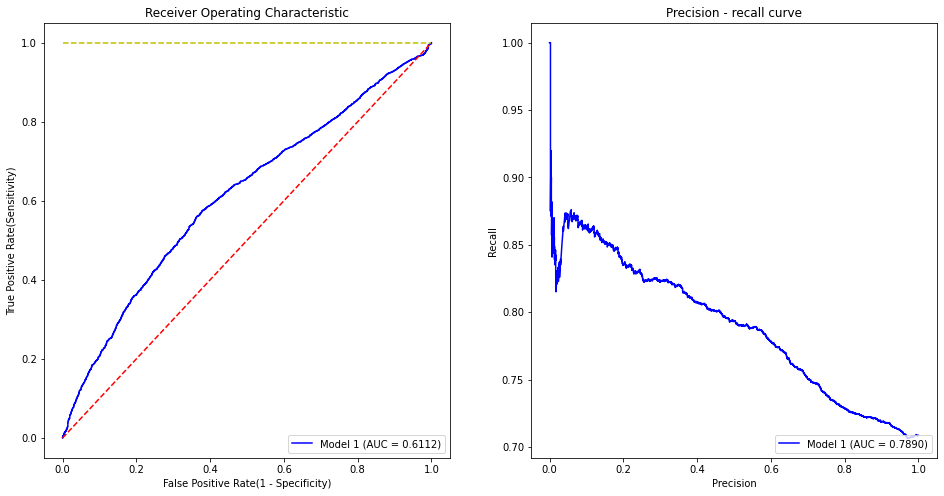

In [79]:
from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


y_pred = loaded_model.predict(x_test_pacu).flatten()

### Classification
# Model Accuracy of test set
model_y = y_pred>=0.5
acc_val = np.mean(model_y==y_test_pacu_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC, AUPRC
false_positive_rate1, true_positive_rate1, threshold = roc_curve(y_test_pacu_bin, y_pred)
precision1, recall1, _ = precision_recall_curve(y_test_pacu_bin, y_pred)

roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
prc_auc1 = auc(recall1, precision1)
print('test set auroc: {:.6f},  test set auprc: {:.6f}'.format(roc_auc1, prc_auc1))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc1)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall1, precision1, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc1)
ax2.legend(loc='lower right')
plt.show()

### test set: pacu + 0.5 preop

test set accuracy:0.72
test set auroc: 0.718708,  test set auprc: 0.788639


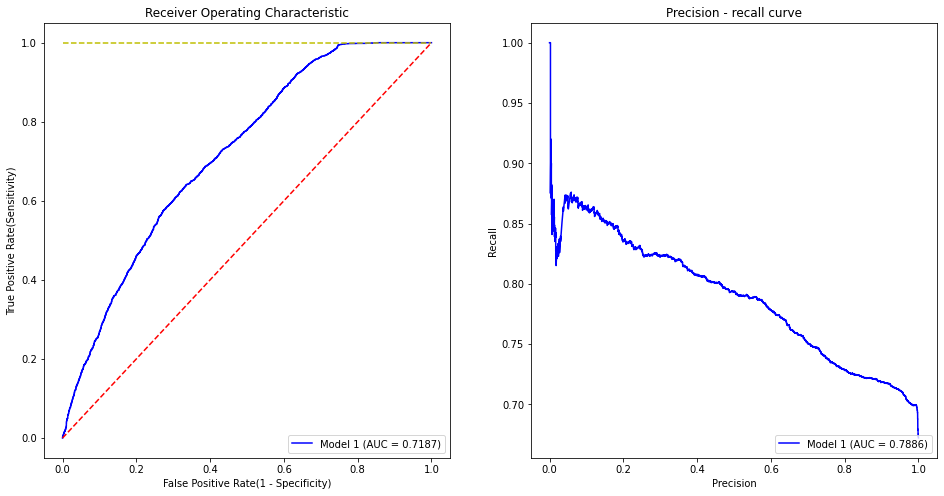

In [80]:
from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


# 전체 test 샘플을 한번에 예측
y_pred2 = loaded_model.predict(x_test2).flatten()


### Classification
# Model Accuracy of test set
model_y = y_pred2>=0.5
acc_val = np.mean(model_y==y_test2_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC, AUPRC
false_positive_rate2, true_positive_rate2, threshold = roc_curve(y_test2_bin, y_pred2)
precision2, recall2, _ = precision_recall_curve(y_test2_bin, y_pred2)

roc_auc2 = auc(false_positive_rate2, true_positive_rate2)
prc_auc2 = auc(recall2, precision2)
print('test set auroc: {:.6f},  test set auprc: {:.6f}'.format(roc_auc2, prc_auc2))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate2, true_positive_rate2, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc2)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall2, precision2, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc2)
ax2.legend(loc='lower right')
plt.show()

### test set: pacu + preop

test set accuracy:0.75
test set auroc: 0.777602,  test set auprc: 0.7871


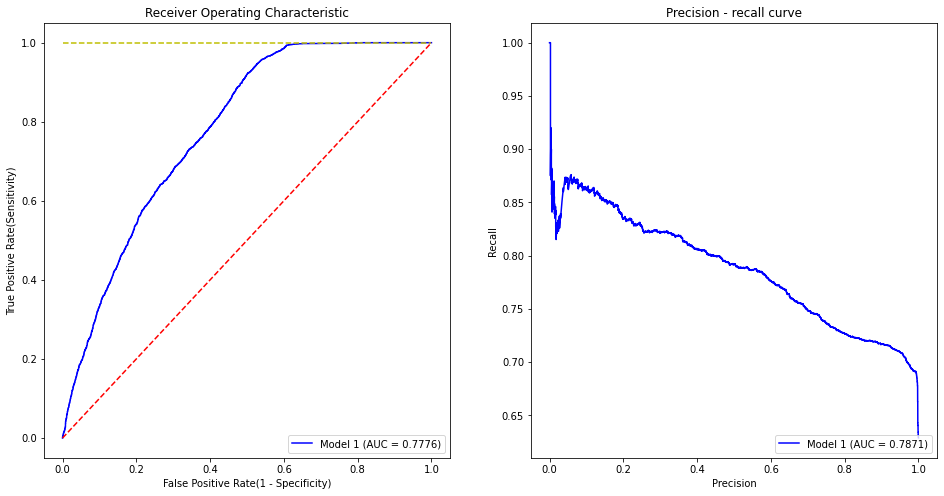

In [8]:
from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


# 전체 test 샘플을 한번에 예측
y_pred3 = loaded_model.predict(x_test).flatten()


### Classification
# Model Accuracy of test set
model_y = y_pred3>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC, AUPRC
false_positive_rate3, true_positive_rate3, threshold = roc_curve(y_test_bin, y_pred3)
precision3, recall3, _ = precision_recall_curve(y_test_bin, y_pred3)

roc_auc3 = auc(false_positive_rate3, true_positive_rate3)
prc_auc3 = auc(recall3, precision3)
print('test set auroc: {:.6f},  test set auprc: {:.4f}'.format(roc_auc3, prc_auc3))


# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate3, true_positive_rate3, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc3)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall3, precision3, 'b', label='Model 1 (AUC = %0.4f)'% prc_auc3)
ax2.legend(loc='lower right')
plt.show()

### test set: pacu + preop (sample weighted)

###Binary classification trained without sample weight###
test set accuracy:0.75
<sample weighted> test set auroc: 0.7863,  test set auprc: 0.8536
<not weighted> test set auroc: 0.7776,  test set auprc: 0.7871


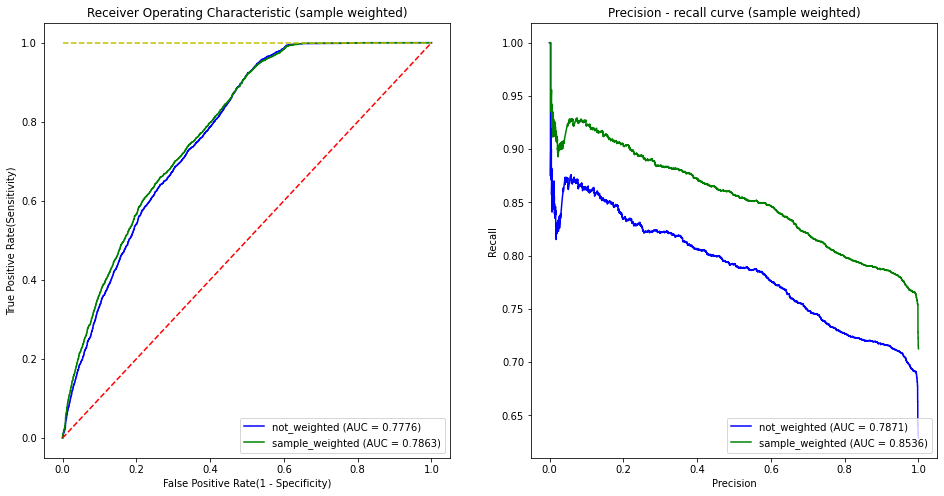

In [16]:
from sklearn.metrics import roc_curve, auc, r2_score, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt


# 전체 test 샘플을 한번에 예측
y_pred3 = loaded_model.predict(x_test).flatten()
print('###Binary classification trained without sample weight###')

### Classification
# Model Accuracy of test set
model_y = y_pred3>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC, AUPRC
false_positive_rate3s, true_positive_rate3s, threshold = roc_curve(y_test_bin, y_pred3, sample_weight = test_w_samp3)
precision3s, recall3s, _ = precision_recall_curve(y_test_bin, y_pred3, sample_weight = test_w_samp3)

roc_auc3s = auc(false_positive_rate3s, true_positive_rate3s)
prc_auc3s = auc(recall3s, precision3s)
print('<sample weighted> test set auroc: {:.4f},  test set auprc: {:.4f}'.format(roc_auc3s, prc_auc3s))


test_w_samp2 = np.ones(shape=(len(y_test),))
# Model AUROC, AUPRC
false_positive_rate3, true_positive_rate3, threshold = roc_curve(y_test_bin, y_pred3, sample_weight = test_w_samp2)
precision3, recall3, _ = precision_recall_curve(y_test_bin, y_pred3, sample_weight = test_w_samp2)

roc_auc3 = auc(false_positive_rate3, true_positive_rate3)
prc_auc3 = auc(recall3, precision3)
print('<not weighted> test set auroc: {:.4f},  test set auprc: {:.4f}'.format(roc_auc3, prc_auc3))



# plotting auprc
fig = plt.figure(figsize=(16,8))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic (sample weighted)')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate3, true_positive_rate3, 'b', label='not_weighted (AUC = %0.4f)'% roc_auc3)
ax1.plot(false_positive_rate3s, true_positive_rate3s, 'g', label='sample_weighted (AUC = %0.4f)'% roc_auc3s)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='lower right')

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve (sample weighted)')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall3, precision3, 'b', label='not_weighted (AUC = %0.4f)'% prc_auc3)
ax2.plot(recall3s, precision3s, 'g', label='sample_weighted (AUC = %0.4f)'% prc_auc3s)
ax2.legend(loc='lower right')
plt.show()

### Plot together

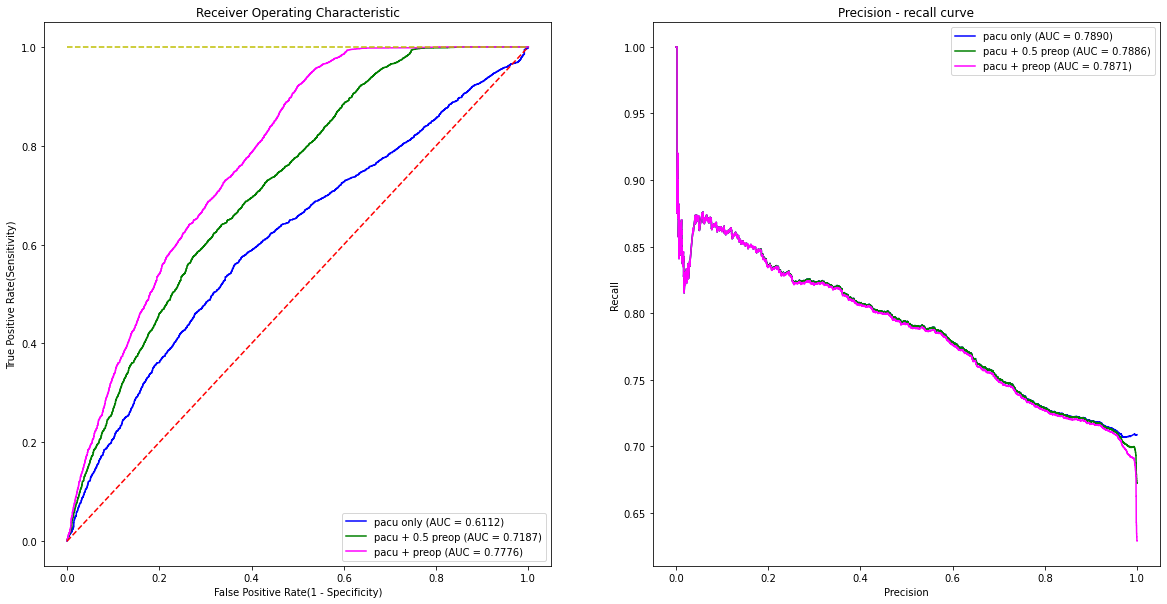

In [82]:
# plotting auprc
fig = plt.figure(figsize=(20,10))
# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')

ax1.plot(false_positive_rate1, true_positive_rate1, 'b', label='pacu only (AUC = %0.4f)'% roc_auc1)
ax1.plot(false_positive_rate2, true_positive_rate2, 'g', label='pacu + 0.5 preop (AUC = %0.4f)'% roc_auc2)
ax1.plot(false_positive_rate3, true_positive_rate3, 'magenta', label='pacu + preop (AUC = %0.4f)'% roc_auc3)
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.legend(loc='best')


# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')

ax2.plot(recall1, precision1, 'b', label='pacu only (AUC = %0.4f)'% prc_auc1)
ax2.plot(recall2, precision2, 'g', label='pacu + 0.5 preop (AUC = %0.4f)'% prc_auc2)
ax2.plot(recall3, precision3, 'magenta', label='pacu + preop (AUC = %0.4f)'% prc_auc3)
ax2.legend(loc='best')
plt.show()


## Confusion matrix

In [83]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve

y_pred = model.predict(x_test).flatten()

# Model AUROC, AUPRC
fpr, tpr, thvals = roc_curve(y_test_bin, y_pred)
optimal_idx = np.argmax(tpr-fpr)
thval = thvals[optimal_idx]

#precision1, recall1, _ = precision_recall_curve(y_test_pacu_bin, y_pred)
print('optimal thval: {}'.format(thval))
tn, fp, fn, tp = confusion_matrix(y_test_bin, y_pred>=thval).ravel()
confusion_matrix(y_test_bin, y_pred>=thval)

optimal thval: 0.6464980244636536


array([[2057, 1890],
       [ 855, 4542]])

### Original confusion matrix

Normalized confusion matrix
[[0.52 0.48]
 [0.16 0.84]]


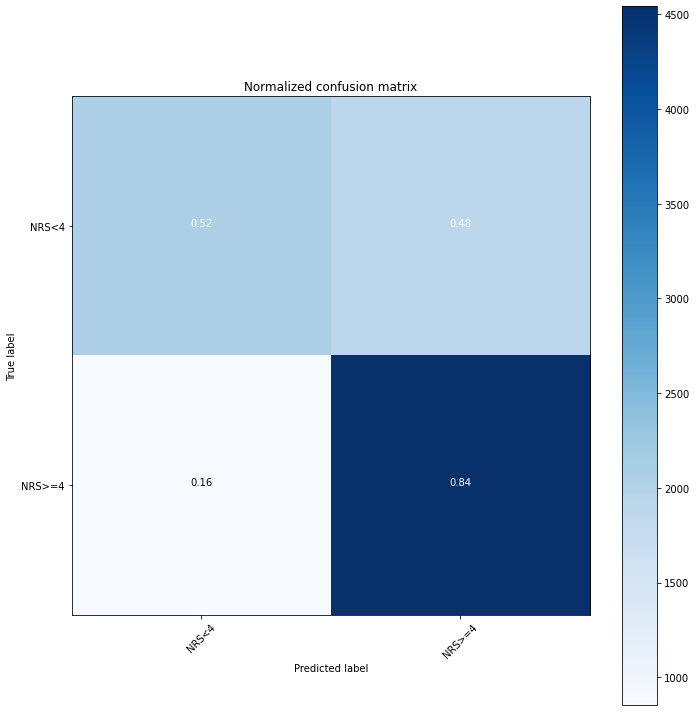

In [86]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_bin, y_pred>=thval)
np.set_printoptions(precision=2)
class_names = ['NRS<4','NRS>=4']


# Plot non-normalized confusion matrix
#print(cnf_matrix)
#plt.figure(figsize=(10,10))
#plt.yaxis.major_formatter(mtick.FormatStrFormatter('%.2e'))
#plot_confusion_matrix(cnf_matrix, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Deloung test

In [ ]:
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    
def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])

def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))
    
def group_preds_by_label(preds, actual):
    X = [p for (p, a) in zip(preds, actual) if a]
    Y = [p for (p, a) in zip(preds, actual) if not a]
    return X, Y

def delong_roc_test(actual, preds_A, preds_B):
    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc2(X_A, Y_A)
    auc_B = auc2(X_B, Y_B)
    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))
    # Two tailed test
    z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    return stat.norm.sf(abs(z))*2

pval = delong_roc_test(y_test_bin.astype(int), y_pred, y)

In [86]:
from scipy.optimize import minimize, curve_fit

def func(thresh):
    return np.mean(y_test_pacu_bin==(y_pred>=thresh))

#res = minimize(func, 0.5,  bounds=((0,1)))
trials = np.arange(100)/100
res = [func(trial) for trial in trials]
res.index(max(res))

0

## Model ROC plot

test set accuracy:0.71
test set auroc: 0.5845937933486571


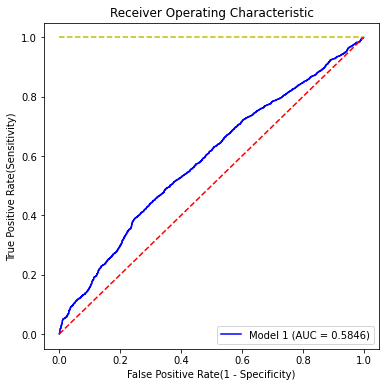

In [31]:
from sklearn.metrics import roc_curve, auc, r2_score
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
model_y = y_pred>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

# Model R_square
#print('test set R2:', r2_score(y_test, y_pred*9))


# Adding evaluation results to file name
# classification
#os.rename(save_path, save_path+'_auc{:.4f}_acc{:.4f}'.format(roc_auc,np.mean(model_y==y_test_bin)))

# regression
os.rename(save_path, 'output/preprocess3/input3-2_PPG+ECG/auc{:.4f}_1D_CNN_{}acc{:.2f}'.format(roc_auc,model_name,acc_val))


# plotting roc
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

In [ ]:
# Model Accuracy of test set
#print('test set accuracy:{:.2f}'.format(np.mean(y_pred>0.5==y_test_bin)))

# Model AUROC
from sklearn.metrics import roc_curve ,auc
from numpy import interp
#pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(solver='liblinear', penalty='12', random_state=1, C=100.0))

#cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(x_))

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

# Model Evaluation: 3 class

## Labeling classes

In [9]:
# labels for y_train
y_train_class = []
for i in range(y_train.shape[0]):
    if y_train[i] <= 3.5:
        y_train_class.append((1,0,0))
    elif 3.5<y_train[i]<=6.5:
        y_train_class.append((0,1,0))
    else:
        y_train_class.append((0,0,1))
        
y_train_class = np.array(y_train_class, int)


# labels for y_val
y_val_class = []
for i in range(y_val.shape[0]):
    if y_val[i] <= 3.5:
        y_val_class.append((1,0,0))
    elif 3.5<y_val[i]<=6.5:
        y_val_class.append((0,1,0))
    else:
        y_val_class.append((0,0,1))
        
y_val_class = np.array(y_val_class, int)

# labels for y_test
y_test_class = []
hist_y_test = [0, 0, 0]
for i in range(y_test.shape[0]):
    if y_test[i] <= 3.5:
        y_test_class.append([1,0,0])
        hist_y_test[0]+=1
    elif 3.5<y_test[i]<=6.5:
        y_test_class.append([0,1,0])
        hist_y_test[1]+=1
    else:
        y_test_class.append([0,0,1])
        hist_y_test[2]+=1
        
y_test_class = np.array(y_test_class, int)
print('y_test class bins: ', hist_y_test)


# labels for y_test
y_test2_class = []
for i in range(y_test2.shape[0]):
    if y_test2[i] <= 3.5:
        y_test2_class.append([1,0,0])
    elif 3.5<y_test2[i]<=6.5:
        y_test2_class.append([0,1,0])
    else:
        y_test2_class.append([0,0,1])
        
y_test2_class = np.array(y_test2_class, int)

# labels for y_test
y_test_pacu_class = []
for i in range(y_test_pacu.shape[0]):
    if y_test_pacu[i] <= 3.5:
        y_test_pacu_class.append([1,0,0])

    elif 3.5<y_test_pacu[i]<=6.5:
        y_test_pacu_class.append([0,1,0])
        
    else:
        y_test_pacu_class.append([0,0,1])
y_test_pacu_class = np.array(y_test_pacu_class, int)

y_test class bins:  [3947, 4015, 1382]


In [18]:
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

y_train_bin2 = y_train >= 7
y_test_bin2 = y_test >= 7
y_val_bin2 = y_val >= 7

## Sample weight

In [124]:
# 3 class에 대한 sample weight
test_w_samp3 = np.ones(shape=(len(y_test),))

mask1 = [(y_class==[1,0,0]).all() for y_class in y_test_class] 
test_w_samp3[mask1]= len(y_test) / hist_y_test[0]

mask1 = [(y_class==[0,1,0]).all() for y_class in y_test_class] 
test_w_samp3[mask1]= len(y_test) / hist_y_test[1]

mask1 = [(y_class==[0,0,1]).all() for y_class in y_test_class] 
test_w_samp3[mask1]= len(y_test) / hist_y_test[2]

print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_test) / hist_y_test[0],len(y_test) / hist_y_test[1],len(y_test) / hist_y_test[2]))

sample weight for class 1: 2.37, class 2: 2.33, class 3: 6.76


In [123]:
# 2 class에 대한 sample weight
test_w_samp2 = np.ones(shape=(len(y_test),))
test_w_samp2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin)
test_w_samp2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin)

test_w_samp2_2 = np.ones(shape=(len(y_test),))
test_w_samp2_2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin2)
test_w_samp2_2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin2)

print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin), len(y_test) / np.sum(~y_test_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin2), len(y_test) / np.sum(~y_test_bin2)))

sample weight for no pain: 1.73, moderate pain: 2.37
sample weight for no pain: 6.76, severe pain: 1.17


## AUROC, AUPRC

### loading the best model(ECG+PPG): auroc0.7709, auprc0.7730

In [19]:
from keras.models import model_from_json


#load_path = 'output/preprocess3/input3-2_PPG+ECG/auroc0.7776_auprc0.7871_1D_CNN_model_bin_conv64_conv64_conv64_conv64_conv64_filter3x2_tanh_bn_maxpool2_globalmaxpool_dropout0.2_dense0_dropout0.3_batch1024_lr_0.001_kinit_kreg0acc0.75'
#load_path = '1D-CNN_ECG+PPG/NRS>=4_val_caseid/1D_CNN_4layers_outputs 1-fold test_setting 100 test data/auc0.7853_batch=256, c1=64, c2=128, c3=32, c4=256, c1filts=11, c2filts=7, c3filts=13, c4filts=5, conv_double=False, globalpool_opt=ave, dropout=0.1, dnodes=0, dropout=0_acc0.77'
load_path = '1D-CNN_ECG+PPG/3class/1D_CNN_4layers_outputs 1-fold test_setting 100 test data/auc0.7709_prc0.7730_batch=256, c1=64, c2=512, c3=128, c4=32, c1filts=7, c2filts=7, c3filts=11, c4filts=13, conv_double=False, globalpool_opt=max, dropout=0.5, dnodes=8, dropout=0_acc0.59'
load_weight_path = load_path+'/model.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
loaded_model = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
loaded_model.load_weights(load_weight_path)
print('done')

loading model...done
loading weights...done


### test set: pacu + preop (sample weighted - 2 class)

test set accuracy:0.59
test set AUROC of moderate pain:0.7709
test set AUPRC of moderate pain:0.8222
test set AUROC of severe pain:0.7586
test set AUPRC of severe pain:0.1429


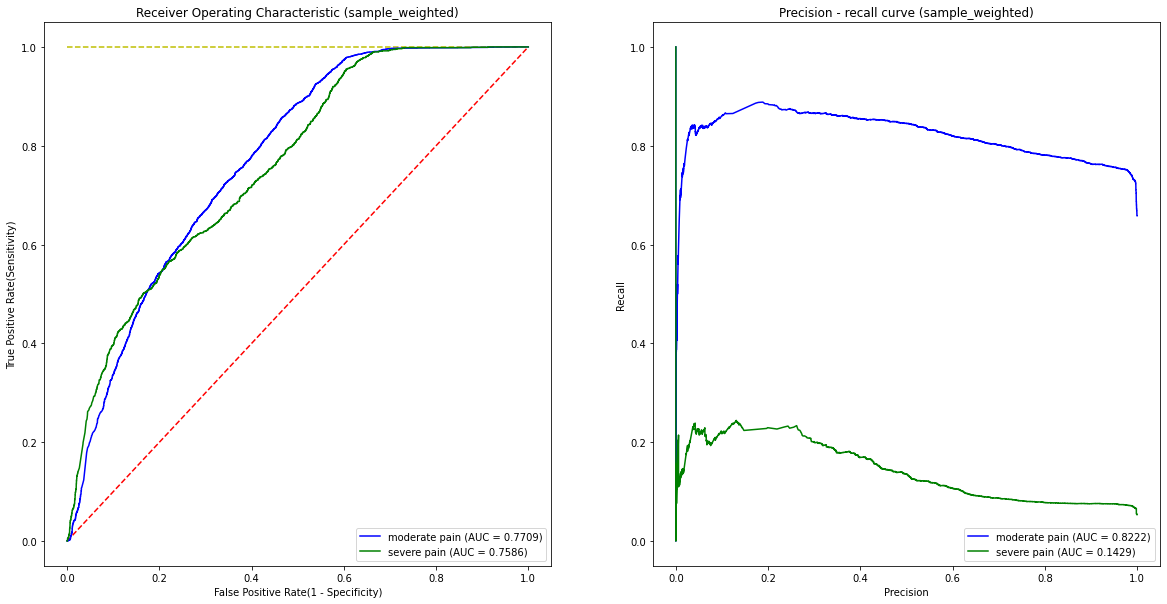

In [121]:
from sklearn.metrics import roc_curve, auc, r2_score, accuracy_score
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

y_pred = loaded_model.predict(x_test)
 

### Classification
# Model Accuracy of test set
l_test = np.argmax(y_test_class, axis=1)
l_pred = np.argmax(y_pred, axis=1)
acc_val = accuracy_score(l_test, l_pred)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC, AUPRC
fig = plt.figure(figsize=(20,10))
# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic (sample_weighted)')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve (sample_weighted)')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')


# moderate pain (NRS>=4)
false_positive_rate, true_positive_rate, threshold = roc_curve((y_test_class[:,1]+y_test_class[:,2])==1, y_pred[:,1]+y_pred[:,2], sample_weight=test_w_samp2)
precision, recall, _ = precision_recall_curve((y_test_class[:,1]+y_test_class[:,2])==1, y_pred[:,1]+y_pred[:,2], sample_weight= test_w_samp2)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC of moderate pain:{:.4f}'.format(roc_auc))
print('test set AUPRC of moderate pain:{:.4f}'.format(prc_auc))
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

# Adding evaluation results to file name
# classification


# severe pain (NRS>=7)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_class[:,2], y_pred[:,2], sample_weight=test_w_samp2_2)
precision, recall, _ = precision_recall_curve(y_test_class[:,2], y_pred[:,2], sample_weight=test_w_samp2_2)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC of severe pain:{:.4f}'.format(roc_auc))
print('test set AUPRC of severe pain:{:.4f}'.format(prc_auc))
ax1.plot(false_positive_rate, true_positive_rate, 'g', label='severe pain (AUC = %0.4f)'% roc_auc)
ax2.plot(recall, precision, 'g', label='severe pain (AUC = %0.4f)'% prc_auc)

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')


#plt.savefig(test_path + '/auroc_auprc.png', bbox_inches="tight", pad_inches=0.5)


### test set: pacu + preop (sample weighted - 3 class)

test set accuracy:0.59
test set AUROC of moderate pain:0.7779
test set AUPRC of moderate pain:0.8377
test set AUROC of severe pain:0.6810
test set AUPRC of severe pain:0.5038


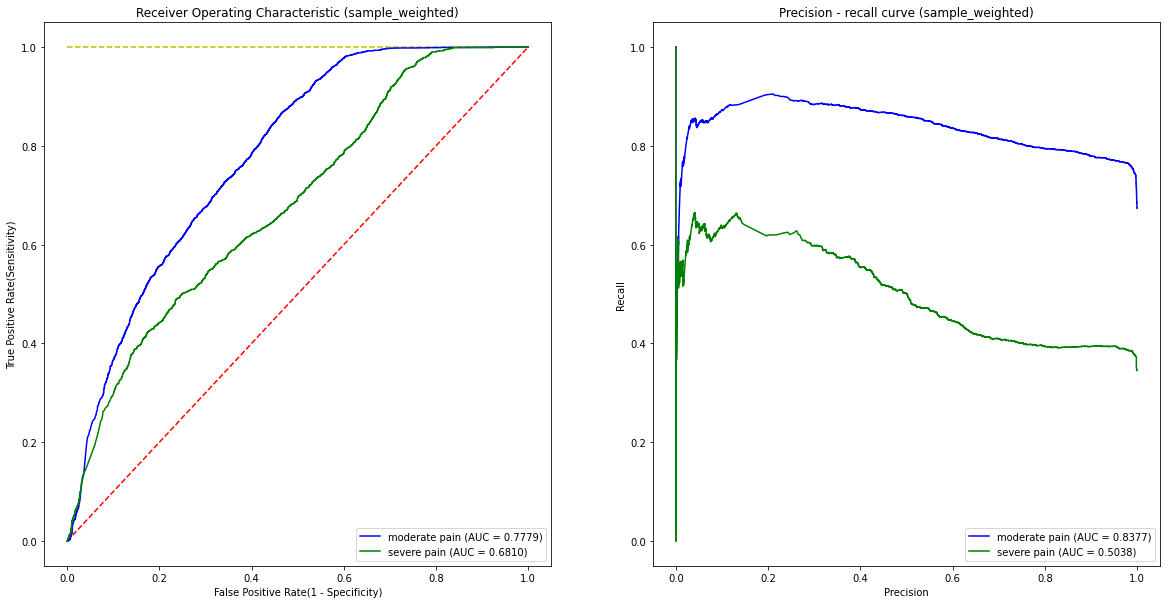

In [20]:
from sklearn.metrics import roc_curve, auc, r2_score, accuracy_score
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

y_pred = loaded_model.predict(x_test)
 

### Classification
# Model Accuracy of test set
l_test = np.argmax(y_test_class, axis=1)
l_pred = np.argmax(y_pred, axis=1)
acc_val = accuracy_score(l_test, l_pred)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC, AUPRC
fig = plt.figure(figsize=(20,10))
# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic (sample_weighted)')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - recall curve (sample_weighted)')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')


# moderate pain (NRS>=4)
false_positive_rate, true_positive_rate, threshold = roc_curve((y_test_class[:,1]+y_test_class[:,2])==1, y_pred[:,1]+y_pred[:,2], sample_weight=test_w_samp3)
precision, recall, _ = precision_recall_curve((y_test_class[:,1]+y_test_class[:,2])==1, y_pred[:,1]+y_pred[:,2], sample_weight= test_w_samp3)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC of moderate pain:{:.4f}'.format(roc_auc))
print('test set AUPRC of moderate pain:{:.4f}'.format(prc_auc))
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

# Adding evaluation results to file name
# classification


# severe pain (NRS>=7)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_class[:,2], y_pred[:,2], sample_weight=test_w_samp3)
precision, recall, _ = precision_recall_curve(y_test_class[:,2], y_pred[:,2], sample_weight=test_w_samp3)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC of severe pain:{:.4f}'.format(roc_auc))
print('test set AUPRC of severe pain:{:.4f}'.format(prc_auc))
ax1.plot(false_positive_rate, true_positive_rate, 'g', label='severe pain (AUC = %0.4f)'% roc_auc)
ax2.plot(recall, precision, 'g', label='severe pain (AUC = %0.4f)'% prc_auc)

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')


#plt.savefig(test_path + '/auroc_auprc.png', bbox_inches="tight", pad_inches=0.5)


## Confusion matrix

In [24]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(3,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.0f}'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 3 classes

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve


y_pred = loaded_model.predict(x_test)

### mooderate pain
y_test1 = (y_test_class[:,1]+y_test_class[:,2])==1
y_pred1 = y_pred[:,1]+y_pred[:,2]

# calculate optimal threshold that minimize 'sensitivity(TPR) + specificity(1-FPR)''
fpr, tpr, thvals = roc_curve(y_test1, y_pred1)
optimal_idx = np.argmax(tpr-fpr)
thval = thvals[optimal_idx]
print('optimal thval: {}'.format(thval))
                             
#precision1, recall1, _ = precision_recall_curve(y_test_pacu_bin, y_pred)

# confusion matrix
cnf_matrix = confusion_matrix(y_test1, y_pred1>=thval)
np.set_printoptions(precision=2)
class_names = ['NRS<4','NRS>=4']

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix for moderate pain')

In [15]:
#np.max([[1,2,3]], axis=1)
np.argmax(y_test_class, axis=1)

array([0, 0, 0, ..., 0, 0, 0])

### moderate pain (NRS>=4)

optimal thval: 0.6747100353240967
Confusion matrix, without normalization
[[2114 1833]
 [ 779 4618]]


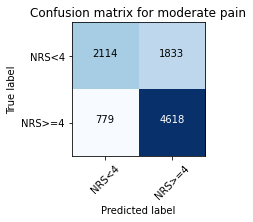

In [169]:
from sklearn.metrics import confusion_matrix, roc_curve


y_pred = loaded_model.predict(x_test)

### mooderate pain
y_test1 = (y_test_class[:,1]+y_test_class[:,2])==1
y_pred1 = y_pred[:,1]+y_pred[:,2]

# calculate optimal threshold that minimize 'sensitivity(TPR) + specificity(1-FPR)''
fpr, tpr, thvals = roc_curve(y_test1, y_pred1)
optimal_idx = np.argmax(tpr-fpr)
thval = thvals[optimal_idx]
print('optimal thval: {}'.format(thval))
                             
#precision1, recall1, _ = precision_recall_curve(y_test_pacu_bin, y_pred)

# confusion matrix
cnf_matrix = confusion_matrix(y_test1, y_pred1>=thval)
np.set_printoptions(precision=2)
class_names = ['NRS<4','NRS>=4']

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix for moderate pain')

optimal thval: 0.6747100353240967
Confusion matrix, without normalization
[[ 5004.62  4339.38]
 [ 2509.07 16178.93]]


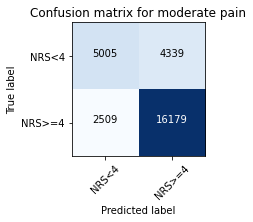

In [25]:
# sample weighted

from sklearn.metrics import confusion_matrix, roc_curve


y_pred = loaded_model.predict(x_test)

### mooderate pain
y_test1 = (y_test_class[:,1]+y_test_class[:,2])==1
y_pred1 = y_pred[:,1]+y_pred[:,2]

# calculate optimal threshold that minimize 'sensitivity(TPR) + specificity(1-FPR)''
fpr, tpr, thvals = roc_curve(y_test1, y_pred1)
optimal_idx = np.argmax(tpr-fpr)
thval = thvals[optimal_idx]
print('optimal thval: {}'.format(thval))
                             
#precision1, recall1, _ = precision_recall_curve(y_test_pacu_bin, y_pred)

# confusion matrix
cnf_matrix = confusion_matrix(y_test1, y_pred1>=thval, sample_weight=test_w_samp3)
np.set_printoptions(precision=2)
class_names = ['NRS<4','NRS>=4']

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix for moderate pain')

### severe pain (NRS>=7)

optimal thval: 0.20926348865032196
Confusion matrix, without normalization
[[6069 1893]
 [ 705  677]]


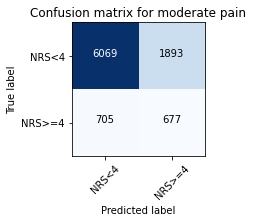

In [171]:
# not sample weighted

from sklearn.metrics import confusion_matrix, roc_curve


y_pred = loaded_model.predict(x_test)

### mooderate pain
y_test2 = (y_test_class[:,2])==1
y_pred2 = y_pred[:,2]

# calculate optimal threshold that minimize 'sensitivity(TPR) + specificity(1-FPR)''
fpr, tpr, thvals = roc_curve(y_test2, y_pred2)
optimal_idx = np.argmax(tpr-fpr)
thval = thvals[optimal_idx]
print('optimal thval: {}'.format(thval))
                             
#precision1, recall1, _ = precision_recall_curve(y_test_pacu_bin, y_pred)

# confusion matrix
cnf_matrix = confusion_matrix(y_test2, y_pred2>=thval)
np.set_printoptions(precision=2)
class_names = ['NRS<7','NRS>=7']

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='Confusion matrix for moderate pain')

# Binary classification - from model training to evaluation

In [7]:
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

In [74]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal


# hyperparamters
num_nodes = [64, 64, 64, 64] #, 64, 64, 64]
kernel_size = 5
pool_size = 2
BATCH_SIZE = 1024
dense_node = 0
dropout_rate = 0.3
dropout_cnn = 0.2
dropout_fc = 0.3
learning_rate = 0.001


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)


# 출력 폴더를 생성
model_name = 'model_bin_'
for num_node in num_nodes:
    model_name += 'conv{}_'.format(num_node)
model_name += 'filter{}x2_tanh_bn_maxpool{}_globalmaxpool_dropout{}_dense{}_dropout{}_batch{}_lr_{}_kinit_kreg{}'.format(kernel_size, pool_size, dropout_cnn, dense_node, dropout_fc, BATCH_SIZE, learning_rate, k_l2)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_path = "output/preprocess3/input3-2_PPG+ECG/1D_CNN_"+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1"])
with strategy.scope():
    
    # build a model
    model = Sequential()
    for num_node in num_nodes:
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        #model.add(LeakyReLU(alpha=0.1))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(BatchNormalization())    
    model.add(GlobalMaxPool1D())
    #model.add(Flatten())
    model.add(Dropout(dropout_cnn))
    #model.add(Activation('sigmoid'))
    #model.add(Dropout(dropout_rate))
    if dense_node != 0:
        model.add(Dense(dense_node, activation='tanh', kernel_initializer=k_init, kernel_regularizer=k_reg))
        model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid'))

    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train, y_train_bin, validation_data = (x_val, y_val_bin), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())


# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test).flatten() # binary는 flatten

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


64-64-64-64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
77/77 [==============================] - ETA: 0s - loss: 0.9434 - acc: 0.5617 - auc_18: 0.5311
Epoch 00001: val_loss improved from inf to 1.44209, saving model to output/preprocess3/input3-2_PPG+ECG/1D_CNN_model_bin_conv64_conv64_conv64_conv64_filter5x2_tanh_bn_maxpool2_globalmaxpool_dropout0.2_dense0_dropout0.3_batch1024_lr_0.001_kinit_kreg0/weights.hdf5
77/77 [==============================] - 18s 228ms/step - loss: 0.9434 - acc: 0.5617 - auc_18: 0.5311 - val_loss: 1.4421 - val_acc: 0.6267 - val_auc_18: 0.6094
Epoch 2/100
77/77 [==============================] - ETA: 0s - loss: 0.7425 - acc: 0.5938 - auc_18: 0.5780
Epoch 00002: val_loss improved from 1.44209 to 0.65432, saving model to output/preprocess3/input3-2_PPG+ECG/1D_CNN_model_bin_conv64_conv64_conv64_conv64_filter5x2_tanh_bn_maxpool2_globalmaxpool_dropout0

test set accuracy:0.70
test set AUROC: 0.7111238924082053
test set AUPRC: 0.7084625510804102


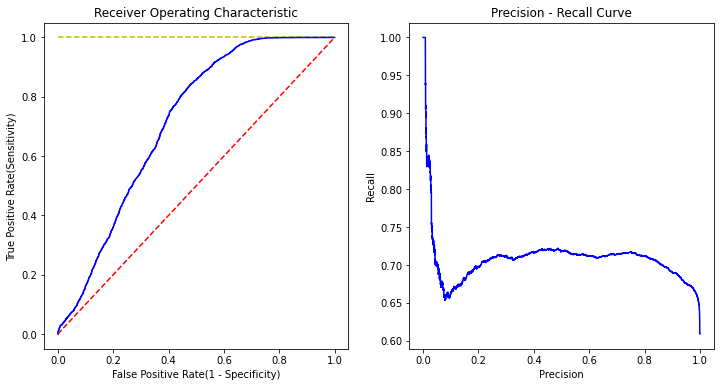

In [75]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
model_y = y_pred>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC:', roc_auc)
print('test set AUPRC:', prc_auc)


# Adding evaluation results to file name
test_path = 'output/preprocess3/input3-2_PPG+ECG/auroc{:.4f}_auprc{:.4f}_1D_CNN_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
os.rename(save_path, test_path)

# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)


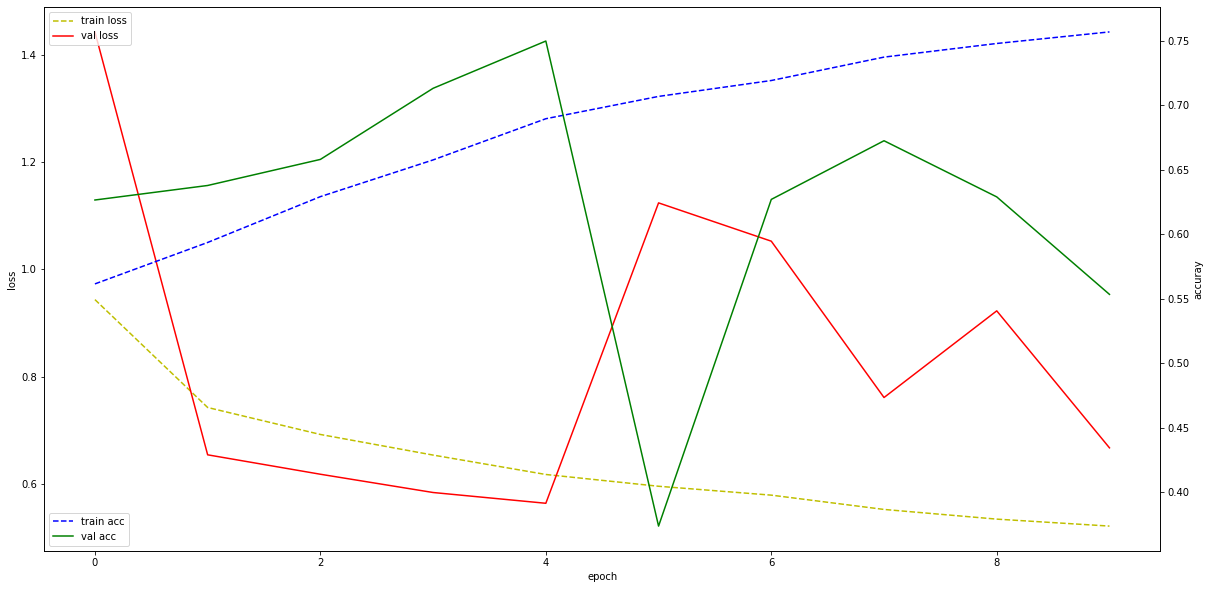

In [76]:
# model auroc 0.719짜리
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [73]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_99 (Conv1D)           (None, 5000, 64)          704       
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 5000, 64)          20544     
_________________________________________________________________
activation_71 (Activation)   (None, 5000, 64)          0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 5000, 64)          256       
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 2500, 64)          0         
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 2500, 64)          20544     
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 2500, 64)        